<a href="https://colab.research.google.com/github/RaianaSeixas/NLT/blob/main/Relevant_Job__Title_Pictures_v13_NLP_division_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Determining Relevant Job Title Pictures**
The objective of this short project is to automatically find relevant pictures for job titles. We are looking for pictures that represent the activities typically associated with that job title, showing people or tools used on the job.
## Dataset
The dataset provided is a .csv file with a set of pictures queried from Google Images, with the following available metadata and pre-extracted features:

* Job Title: the job we are trying to get pictures for.

* Pic Title: the picture title according to Google Images.

* Num Resumes: the number of resumes we have available for the job title. This indicates how popular /common the job title is.

* Google Position: the position of the image in the search results.

* Strict Face Count: face count according to a high-precision face recognition algorithm from OpenCV. When it detects a face, it is a human face almost 100% of the time, but it doesn't detect all human faces.

* Relaxed Face Count: face count according to a high-recall face recognition algorithm from OpenCV. It detects human faces almost 100% of the time, but it also confuses some other shapes and objects with human faces.

* KB size: size of the image in kilobytes.

* Height: pixel height of the image.

* Width: pixel width of the image.

* Resolution: total pixels in the image.

* Text regions: number of text regions identified in the image, also using OpenCV.

* Picture URL: the URL of the image.

* Manual Label: a label indicating if the picture is good (relevant) or bad (irrelevant). 

##Methodology
The feature "Manual Label" is available only for  around 20% of the dataset. For this reason, I decided to use unsupervised learning to create the model and use the labaled data to evaluate the quality of the model.
----------
Author: Raiana Roland Seixas
09/07/2022

# Data load & Libraries

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [120]:
import nltk
ps = nltk.PorterStemmer()
wn=nltk.WordNetLemmatizer()
nltk.download("popular")
stopwords = nltk.corpus.stopwords.words('english')
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [121]:
from google.colab import files

In [122]:
!git clone https://github.com/RaianaSeixas/NLT
%cd NLT

Cloning into 'NLT'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 48 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.
/content/NLT/NLT/NLT/NLT


In [123]:
df=pd.read_csv('occupation_pictures.csv')
df

,Job Title,Pic Title,Num Resumes,Google Position,Strict Face Count,Relaxed Face Count,KB size,Height,Width,Resolution,Text Regions,Picture URL,Manual Label
0,3D Modeler,Our Top 19 3D Modeling Software Picks ...,1261,0,0,7,276.763672,1917,2301,4411017,2,https://format-magazine-production-res.cloudin...,NaN
1,3D Modeler,7 Tips for Beginner 3D Modelers ...,1261,1,0,3,44.343750,340,747,253980,5,http://static1.squarespace.com/static/5320f582...,NaN
2,3D Modeler,How to Become an Expert 3D Modeler ...,1261,2,0,2,43.088867,380,660,250800,8,https://www.gamedesigning.org/wp-content/uploa...,NaN
3,3D Modeler,What is 3D Modeling & What's It Used For?,1261,3,0,2,78.623047,330,750,247500,1,https://cdn.conceptartempire.com/images/04/522...,NaN
4,3D Modeler,Shoofping 3D Modeler ...,1261,4,0,1,97.517578,1075,1909,2052175,3,http://shoofping.com/wp-content/uploads/2017/1...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,Wind Turbine Engineer,Wind turbine technician fastest-growing ...,61,4,0,0,89.249023,720,1280,921600,0,https://i.ytimg.com/vi/lUf2mOYp1d4/maxresdefau...,good
654,Wind Turbine Engineer,How to Become a Wind Energy Engineer ...,61,5,0,0,37.949219,200,300,60000,0,https://www.environmentalscience.org/wp-conten...,NaN
655,Wind Turbine Engineer,Wind - Get Into Energy,61,6,0,1,324.730469,500,750,375000,1,http://getintoenergy.com/wp-content/uploads/20...,good
656,Wind Turbine Engineer,Wind-energy programs yield engineering ...,61,7,0,1,36.197266,920,613,563960,0,https://s.hdnux.com/photos/20/15/22/4248747/3/...,good


In [124]:
data=df.drop(columns=['Picture URL'])

In [125]:
data['Manual Label'].describe()

count      133
unique       2
top       good
freq        91
Name: Manual Label, dtype: object

In [126]:
data['Pic Title'].describe()

count                            658
unique                           593
top       Bureau of Labor Statistics
freq                              17
Name: Pic Title, dtype: object

# Exploratory Analysis

# Data Preprocessing

### Clean up text

In [127]:
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

data['Job Title'] = data['Job Title'].apply(lambda x: clean_text(x.lower()))
data['Pic Title'] = data['Pic Title'].apply(lambda x: clean_text(x.lower()))
#data.head()

In [128]:
#data.columns

In [129]:
#documents_new = data['Pic Title'].values
#documents_new

### Stem / Lemmatize text

In [130]:
def stemming(text):
  stemmed=[ps.stem(word) for word in text]
  return stemmed

data['Stem Job Title'] = data['Job Title'].apply(lambda x: stemming(x))
data['Stem Pic Title'] = data['Pic Title'].apply(lambda x: stemming(x))
#data

In [131]:
#data[data['Manual Label']=='bad']

In [132]:
#data[data['Manual Label']=='good']

In [133]:
data.head()

,Job Title,Pic Title,Num Resumes,Google Position,Strict Face Count,Relaxed Face Count,KB size,Height,Width,Resolution,Text Regions,Manual Label,Stem Job Title,Stem Pic Title
0,"[3d, modeler]","[top, 19, 3d, modeling, software, picks, ]",1261,0,0,7,276.763672,1917,2301,4411017,2,NaN,"[3d, model]","[top, 19, 3d, model, softwar, pick, ]"
1,"[3d, modeler]","[7, tips, beginner, 3d, modelers, ]",1261,1,0,3,44.343750,340,747,253980,5,NaN,"[3d, model]","[7, tip, beginn, 3d, model, ]"
2,"[3d, modeler]","[become, expert, 3d, modeler, ]",1261,2,0,2,43.088867,380,660,250800,8,NaN,"[3d, model]","[becom, expert, 3d, model, ]"
3,"[3d, modeler]","[3d, modeling, whats, used]",1261,3,0,2,78.623047,330,750,247500,1,NaN,"[3d, model]","[3d, model, what, use]"
4,"[3d, modeler]","[shoofping, 3d, modeler, ]",1261,4,0,1,97.517578,1075,1909,2052175,3,NaN,"[3d, model]","[shoofp, 3d, model, ]"


## Feature engineering

In [134]:
arr1 = data['Stem Job Title'].values # first information (common small)
arr2 = data['Stem Pic Title'].values # second information
n = arr1.shape[0] # n = 658
lista = []
divide = []
for i in range(n):
  aux =0
  c1 = list(arr1[i])
  for x in arr1[i]:
    c2 = list(arr2[i])
    if(c2.count(x) != 0):
      aux = aux + 1
  lista.append(aux)
  try:
   divide.append(len(c1)/aux)
  except:
   divide.append(0)
#print(lista)
#print(divide)

In [135]:
documents = data['Stem Pic Title'].values
job = data['Stem Job Title'].values
corpus = job + documents

In [136]:
def text_variable(corpus,documents,cluster_k):
  def lista_organiza(arr_conv):
    n = arr_conv.shape[0]
    lista =[]
    for i in range(n):
      arr = arr_conv[i]
      ans =' '.join(arr)
      lista.append(ans)
    resp = lista
    return resp  

  corpus = lista_organiza(corpus)
  documents = lista_organiza(documents)

  vectorizer = TfidfVectorizer(stop_words='english')
  XW = vectorizer.fit_transform(corpus)

  model = KMeans(n_clusters=cluster_k, init='k-means++', max_iter=100, n_init=1)
  model.fit(XW)
  resp = []
  for x in documents:
    doc=[]
    doc.append(x)
    Y = vectorizer.transform(doc)
    prediction = model.predict(Y)
    resp.append(prediction[0])
  return resp

In [137]:
def text_variable_Birch(corpus, documents,cluster_k):
  def lista_organiza(arr_conv):
    n = arr_conv.shape[0]
    lista =[]
    for i in range(n):
      arr = arr_conv[i]
      ans =' '.join(arr)
      lista.append(ans)
    resp = lista
    return resp  
  corpus = lista_organiza(corpus)
  documents = lista_organiza(documents)
  vectorizer = TfidfVectorizer(stop_words='english')

  XW = vectorizer.fit_transform(corpus)

  model = Birch(threshold=0.01, n_clusters = cluster_k)
  model.fit(XW)
  resp = []
  for x in documents:
    doc=[]
    doc.append(x)
    Y = vectorizer.transform(doc)
    prediction = model.predict(Y)
    resp.append(prediction[0])
  return resp

In [138]:
#Drop target feature

#X = data.drop(columns=['Manual Label','Job Title','Pic Title','Stem Job Title','Stem Pic Title','KB size','Num Resumes','Google Position','Width','Text Regions']) 
X = data.drop(columns=['Manual Label','Job Title','Pic Title','Stem Job Title','Stem Pic Title','KB size','Resolution','Width']) 
#'Height','Num Resumes','Google Position','Text Regions'
#X = data.drop(columns=['Manual Label','Stem Job Title','Stem Pic Title']) 
X['Division']=divide
#X['Career'] = career
W = X.copy()

In [139]:
ncluster = [9,9]
resp = text_variable(corpus,documents,ncluster[0])
X['Doc_title'] = resp
resp = text_variable(corpus,job,ncluster[1]) 
X['Doc_job'] = resp
X

,Num Resumes,Google Position,Strict Face Count,Relaxed Face Count,Height,Text Regions,Division,Doc_title,Doc_job
0,1261,0,0,7,1917,2,1.0,0,0
1,1261,1,0,3,340,5,1.0,0,0
2,1261,2,0,2,380,8,1.0,0,0
3,1261,3,0,2,330,1,1.0,0,0
4,1261,4,0,1,1075,3,1.0,0,0
...,...,...,...,...,...,...,...,...,...
653,61,4,0,0,720,0,1.5,7,2
654,61,5,0,0,200,0,1.5,7,2
655,61,6,0,1,500,1,3.0,2,2
656,61,7,0,1,920,0,3.0,7,2


In [140]:
resp = text_variable_Birch(corpus,documents,ncluster[0])
W['Doc_title'] = resp
resp = text_variable_Birch(corpus,job,ncluster[1])
W['Doc_job'] = resp
W 

,Num Resumes,Google Position,Strict Face Count,Relaxed Face Count,Height,Text Regions,Division,Doc_title,Doc_job
0,1261,0,0,7,1917,2,1.0,0,0
1,1261,1,0,3,340,5,1.0,0,0
2,1261,2,0,2,380,8,1.0,0,0
3,1261,3,0,2,330,1,1.0,0,0
4,1261,4,0,1,1075,3,1.0,0,0
...,...,...,...,...,...,...,...,...,...
653,61,4,0,0,720,0,1.5,1,1
654,61,5,0,0,200,0,1.5,1,1
655,61,6,0,1,500,1,3.0,1,1
656,61,7,0,1,920,0,3.0,1,1


###Data split and scaling

In [141]:
''' Data (with labels) to test the model '''

index_no = data['Manual Label'].notna()

In [142]:
''' Scaling'''

scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)
Ws = scaler.fit_transform(W)

# Predictive Model

## K-means

In [143]:
y_pred = KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=1).fit_predict(Xs)

In [144]:
# get the elements containing label (we will use it to evaluate the method)
y = data['Manual Label'].replace({'good':0, 'bad':1})
y_real = y[index_no].astype(int)
X_eval= Xs[index_no,:]
y_mod = y_pred[index_no]



               precision    recall  f1-score   support

      0-Good       0.69      0.99      0.81        91
       1-Bad       0.50      0.02      0.05        42

    accuracy                           0.68       133
   macro avg       0.59      0.51      0.43       133
weighted avg       0.63      0.68      0.57       133



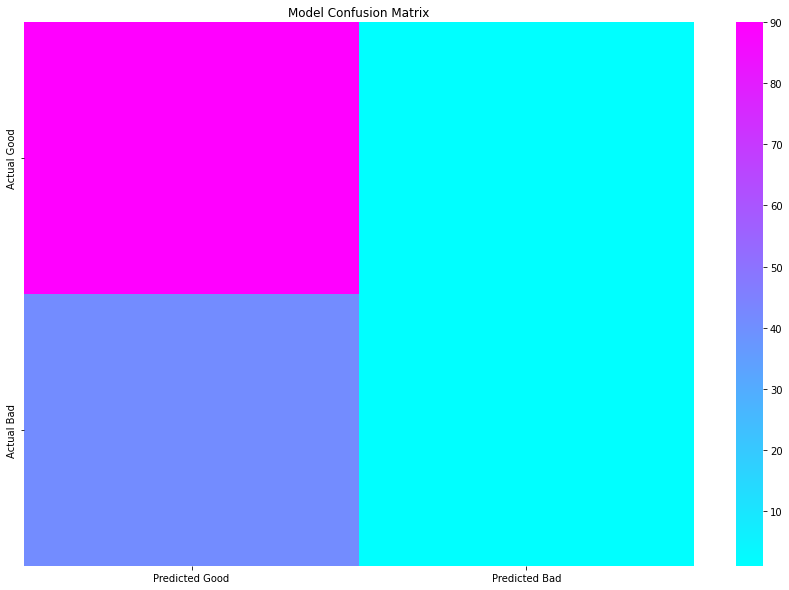

In [145]:
# Classification Report
print('\n\n', classification_report(y_real, y_mod, target_names=['0-Good', '1-Bad']))
# Confusion Matrix
con_matrix = pd.DataFrame(confusion_matrix(y_real, y_mod), columns=['Predicted Good', 'Predicted Bad'], index=['Actual Good', 'Actual Bad'])
  
plt.figure(figsize=(15,10))
sns.heatmap(data=con_matrix, cmap='cool');
plt.title('Model Confusion Matrix')
plt.show()

In [146]:
con_matrix 

,Predicted Good,Predicted Bad
Actual Good,90,1
Actual Bad,41,1


In [147]:
prec = precision_score(y_real, y_mod)
rec = recall_score(y_real, y_mod)
f1 = f1_score(y_real, y_mod)
acc = accuracy_score(y_real, y_mod)
print('precision=',prec)
print('recall=',rec)
print('f1-score=',f1)
print('accuracy=',acc)

precision= 0.5
recall= 0.023809523809523808
f1-score= 0.04545454545454545
accuracy= 0.6842105263157895


## Birch:  Balanced Iterative Reducing and Clustering using Hierarchies

In [148]:
# “threshold” and “n_clusters” are the hyperparameters

Considering metritcs found using KMeans method Birch unsupervised learning was used to create new features describing document title and job description in order to replace the features created using KMeans method

In [149]:
model = Birch(n_clusters=2, threshold=0.01)
# fit the model
model.fit(Ws)
y_calc = model.predict(Ws)
y_mod = y_calc[index_no]



               precision    recall  f1-score   support

      0-Good       0.78      0.84      0.81        91
       1-Bad       0.58      0.50      0.54        42

    accuracy                           0.73       133
   macro avg       0.68      0.67      0.67       133
weighted avg       0.72      0.73      0.72       133



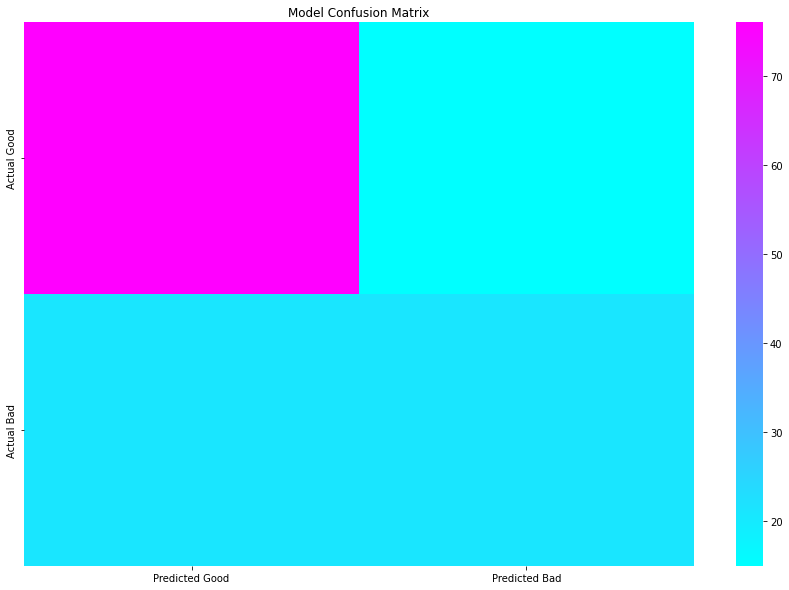

In [150]:
# Classification Report
print('\n\n', classification_report(y_real, y_mod, target_names=['0-Good', '1-Bad']))
# Confusion Matrix
con_matrix = pd.DataFrame(confusion_matrix(y_real, y_mod), columns=['Predicted Good', 'Predicted Bad'], index=['Actual Good', 'Actual Bad'])
  
plt.figure(figsize=(15,10))
sns.heatmap(data=con_matrix, cmap='cool');
plt.title('Model Confusion Matrix')
plt.show();

In [151]:
con_matrix 

,Predicted Good,Predicted Bad
Actual Good,76,15
Actual Bad,21,21


In [152]:
prec = precision_score(y_real, y_mod)
rec = recall_score(y_real, y_mod)
f1 = f1_score(y_real, y_mod)
acc = accuracy_score(y_real, y_mod)
print('precision=',prec)
print('recall=',rec)
print('f1-score=',f1)
print('accuracy=',acc)

precision= 0.5833333333333334
recall= 0.5
f1-score= 0.5384615384615384
accuracy= 0.7293233082706767


## Printing Results

In [153]:
#y = data['Manual Label'].replace({'good':0, 'bad':1})
lista = []
for yi in y_calc:
  if(yi == 0):
    lista.append('good')
  else:
    lista.append('bad')

In [154]:
df['Predict Label'] = lista

In [155]:
Arq = "output_excel.xlsx"
df.to_excel(Arq)
files.download(Arq)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [156]:
Arq = "output_csv.csv"
df.to_csv(Arq)
files.download(Arq)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>